# Deep Learning for Medical Image Classification
----------------------
### Table of Contents
- **Background**
- **Data preprocessing**
- **Shallow convolutional neural network and utility functions**
    - shallow model implementation
    - train model function
    - learning curve plotting
    - test model function
    - plotting ROC curve
    - question
- **Deep convolutional neural network**
- **Using a pretrained model**
    - pretrained model implementation
    - question
- **Model interpretability with Grad-CAM**
----------------------

### Section 1: Background

Radiologists rely on chest X-rays to diagnose a wide range of pulmonary diseases. One such condition is pneumonia, an inflammatory lung disease characterized by the inflammation of air sacs in the lungs. Pneumonia can be caused by both virus and bacteria, and can lead to significant consequences if left untreated.

In this project, we use Convolutional Neural Networks (CNNs) to classify if a patient is suffering from pneumonia or not using their chest X-rays. CNNs, as discussed in class, have proven to be highly effective in identifying patterns and features from images, making them an ideal choice for this use-case.

We start with a shallow CNN, which serves as a baseline model. We then extend the shallow CNN to a deeper CNN architecture, with more parameters. Finally, we fine-tune a pre-trained model, leveraging the knowledge the model gained from training on a large dataset such as ImageNet. Throughout the project, we will track the training of each model and also measure the performance using appropriate evaluation metrics. In the end, we use Grad-CAM, to better understand and interpret the decisions made by our deep learning model.

Heads up: Although care has been taken to ensure we see consistent results across hardware, completely reproducible results are not guaranteed when using different platforms, or versions in Pytorch [<sup>1</sup>](#fn1). Hence for this project, it is not expected for everyone to have the same results.



<span id="fn1"> <sup>1</sup> https://pytorch.org/docs/stable/notes/randomness.html</span>

----------------------



#### Imports and settings

In [ ]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

import torch
import numpy as np
import random

# please do not modify this!
seed = 89802024

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed) if torch.cuda.is_available() else None
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)

device = torch.device("cuda" if torch.backends.mps.is_available() else "cpu")
print(f"Device: {device}")


Device: cuda


### Section 2: Data visualization & preprocessing

Let's start by getting a sense of the data through visualizing a few raw images from our dataset.

----------------------


Normal files: ['/Users/surabhisunil/Documents/sem3/ML fot Healthcare/mp3/mp3/chest_xray/val/NORMAL/NORMAL2-IM-1427-0001.jpeg', '/Users/surabhisunil/Documents/sem3/ML fot Healthcare/mp3/mp3/chest_xray/val/NORMAL/NORMAL2-IM-1430-0001.jpeg', '/Users/surabhisunil/Documents/sem3/ML fot Healthcare/mp3/mp3/chest_xray/val/NORMAL/NORMAL2-IM-1431-0001.jpeg', '/Users/surabhisunil/Documents/sem3/ML fot Healthcare/mp3/mp3/chest_xray/val/NORMAL/NORMAL2-IM-1436-0001.jpeg', '/Users/surabhisunil/Documents/sem3/ML fot Healthcare/mp3/mp3/chest_xray/val/NORMAL/NORMAL2-IM-1437-0001.jpeg', '/Users/surabhisunil/Documents/sem3/ML fot Healthcare/mp3/mp3/chest_xray/val/NORMAL/NORMAL2-IM-1438-0001.jpeg', '/Users/surabhisunil/Documents/sem3/ML fot Healthcare/mp3/mp3/chest_xray/val/NORMAL/NORMAL2-IM-1440-0001.jpeg', '/Users/surabhisunil/Documents/sem3/ML fot Healthcare/mp3/mp3/chest_xray/val/NORMAL/NORMAL2-IM-1442-0001.jpeg']
Pneumonia files: ['/Users/surabhisunil/Documents/sem3/ML fot Healthcare/mp3/mp3/chest_xra

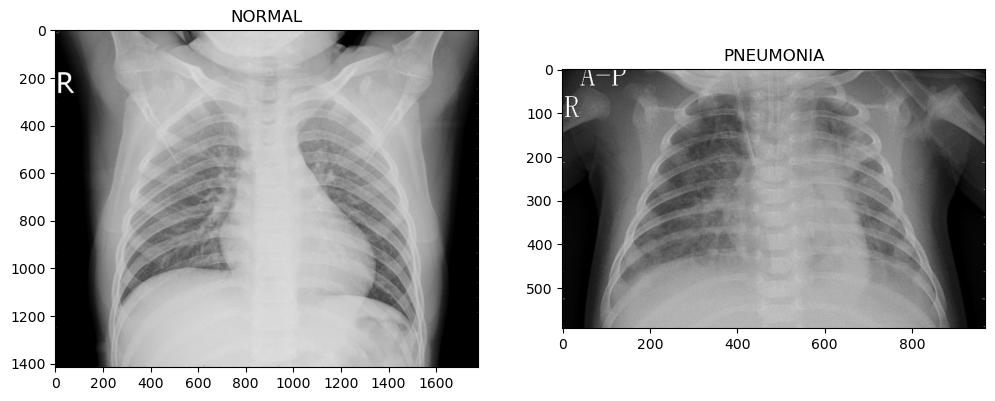

In [ ]:
import matplotlib.pyplot as plt
import glob
import os

def plot_samples(data_dir, dataset='train'):
    set_path = os.path.join(data_dir, dataset)

    normal_files = sorted(glob.glob(os.path.join(set_path, 'NORMAL/*.jpeg')))
    pneumonia_files = sorted(glob.glob(os.path.join(set_path, 'PNEUMONIA/*.jpeg')))

    # Print the file lists to check if they are empty
    print("Normal files:", normal_files)
    print("Pneumonia files:", pneumonia_files)

    # Handle empty lists
    if not normal_files or not pneumonia_files:
        print(f"No images found in {set_path}/NORMAL or {set_path}/PNEUMONIA. Skipping plotting.")
        return

    # Choose first image in 'NORMAL' and 'PNEUMONIA' folders
    normal_image_path = normal_files[0]
    pneumonia_image_path = pneumonia_files[0]

    fig, ax = plt.subplots(1, 2, figsize=(12, 12))

    ax[0].imshow(plt.imread(normal_image_path), cmap='gray')
    ax[0].set_title('NORMAL')

    ax[1].imshow(plt.imread(pneumonia_image_path), cmap='gray')
    ax[1].set_title('PNEUMONIA')

    plt.show()

# Update your data path here
data_dir = "C:/Users/Thekk008/Downloads/mp3/mp3/chest_xray"
#data_dir=

# Plot images from validation set
plot_samples(data_dir, 'val')

Next, we'll preprocess our image dataset to a format suitable for input into our CNNs. This involves converting the images into PyTorch tensors. First, we'll load the images into datasets, and then apply essential transformations like resizing and normalization. In PyTorch, instead of using `torch.utils.data.Dataset` to create datasets like we did in PyTorch tutorial, we will use an adapted version of the `torchvision.datasets.ImageFolder` class, which provides an easier way to load image data. Since the provided validation dataset is smaller, we divide the training dataset into training and validation datasets. We will then create data loaders from these datasets including the transformations. Follow the comments in the cell below to create the train, test, and validation data loaders.

In [ ]:
from typing import Tuple, Any
from functools import lru_cache
from torchvision.datasets import ImageFolder as _ImageFolder

class ImageFolder(_ImageFolder):
    """
    The ImageFolder provided by torchvision reads from memory every time it's
    indexed. Here, we use an LRU cache so that each image is only read from
    memory once. This will require ~1.5 gigabyte of RAM.

    Compared to the naive implementation, this speeds up training ~60x.
    """
    @lru_cache(maxsize = 10_000)
    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """
        Args:
            index (int): Index

        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        """
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return sample, target


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

'''
target_size = (112, 112)

transform = transforms.Compose([
    # Resize images to target size

    # Convert images to tensors

    # Normalize with ImageNet mean and standard deviation ( a common practice )

])
'''

target_size = (112, 112)
ImageNet_mean = [0.485, 0.456, 0.406]
ImageNet_std = [0.229, 0.224, 0.225]

# All transforms are applued to the input one by one
# to add custom transform - transforms.Lambda(func_name)
transform = transforms.Compose([
    # Resize images to target size
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize(target_size),

    # Convert images to tensors
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



train_dataset = ImageFolder(os.path.join(data_dir, 'train'), transform=transform)
test_dataset = ImageFolder(os.path.join(data_dir, 'test'), transform=transform)


# Divide 'train_dataset' into train_dataset (80%) and valid_dataset (20%)
train_size = int(0.8 * len(train_dataset))
valid_size = len(train_dataset) - train_size
train_dataset, valid_dataset = random_split(train_dataset, [train_size, valid_size])


# Create data loaders, use a batch size of '64', set shuffle to 'False' and workers to '0'
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)



Run the following code to verify that you have created the data loaders properly.

In [ ]:
from tqdm.auto import tqdm

def verify_loader_size(dataloader, dataset):
    samples = 0
    for batch, labels in tqdm(dataloader):
        samples += len(batch)
    return samples == len(dataset)

# This will take awhile as the images are loaded into memory and cached for the first time.
assert (
    verify_loader_size(train_loader, train_dataset) and
    verify_loader_size(test_loader, test_dataset) and
    verify_loader_size(valid_loader, valid_dataset)
)

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

In [ ]:
# Notice how much faster it is after caching!
assert (
    verify_loader_size(train_loader, train_dataset) and
    verify_loader_size(test_loader, test_dataset) and
    verify_loader_size(valid_loader, valid_dataset)
)

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

### Section 3: Shallow Convolutional Neural Network

Once the dataloaders are created, we will now train a shallow Convolutional Neural Network (CNN). The architecture for the model has been provided. Please take some time to understand it and fill the class `CNNShallow`, `ReLU` can be used as activation function for all the models. The starter code for training and evaluating the model has also been given. You need to fill in the `train_model`, `test_model`, `plot_learning_curves`, `plot_roc_curve` functions.

After completing these functions, you will evaluate the Shallow CNN model. Examine the learning curves, and load the model's state dictionary from the epoch that you consider optimal and use that model for evaluation.


First, define the CNNShallow class with the layer definitions shown below.

| Layer    | Parameters                                           |
|---------|------------------------------------------------------|
| Conv2d  | 64 3x3 convolutional kernels with padding=1|
| ReLU
| MaxPool2d| 4x4 with stride=2                            |
| Conv2d  | 64 3x3 convolutional kernels with padding=1 |
|  ReLU
| MaxPool2d| 4x4 with stride=2
| Flatten |           |
| Linear  | with 2 outputs                   |


In [ ]:
from torch import nn

class CNNShallow(nn.Module):
    def __init__(self, input_shape=(3, 112, 112)):
        super(CNNShallow, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=4, stride=2)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=4, stride=2)
        self.flatten = nn.Flatten()

        # Dynamically calculate the input size for the fully connected layer
        self._initialize_weights(input_shape)

        self.fc = nn.Linear(in_features=self._to_linear, out_features=2)

    def _initialize_weights(self, input_shape):
        with torch.no_grad():
            x = torch.zeros(1, *input_shape)
            x = self.conv1(x)
            x = self.relu1(x)
            x = self.pool1(x)
            x = self.conv2(x)
            x = self.relu2(x)
            x = self.pool2(x)
            self._to_linear = x.numel() // x.shape[0]  # Ensure the correct size for the fully connected layer

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

cnn_model = CNNShallow()

from torchsummary import summary
summary(cnn_model, (3, 112, 112), device='cpu')


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           1,792
              ReLU-2         [-1, 64, 112, 112]               0
         MaxPool2d-3           [-1, 64, 55, 55]               0
            Conv2d-4           [-1, 64, 55, 55]          36,928
              ReLU-5           [-1, 64, 55, 55]               0
         MaxPool2d-6           [-1, 64, 26, 26]               0
           Flatten-7                [-1, 43264]               0
            Linear-8                    [-1, 2]          86,530
Total params: 125,250
Trainable params: 125,250
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.14
Forward/backward pass size (MB): 17.34
Params size (MB): 0.48
Estimated Total Size (MB): 17.96
----------------------------------------------------------------


Now let's instantiate the CNNShallow class and inspect it's architecture.

In [ ]:
cnn_model = CNNShallow()

print(cnn_model)

CNNShallow(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=43264, out_features=2, bias=True)
)


Using `torchsummary` module, let us verify if the model created matches the architecture. Your output should look like this:

<figure>
    <center>
        <img src="images/cnn_shallow_arch.png" width="600" height="400">
        <figcaption>Shallow CNN Architecture</figcaption>
     </center>
</figure>

In [ ]:
cnn_model = CNNShallow()

from torchsummary import summary
summary(cnn_model, (3, 112, 112), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           1,792
              ReLU-2         [-1, 64, 112, 112]               0
         MaxPool2d-3           [-1, 64, 55, 55]               0
            Conv2d-4           [-1, 64, 55, 55]          36,928
              ReLU-5           [-1, 64, 55, 55]               0
         MaxPool2d-6           [-1, 64, 26, 26]               0
           Flatten-7                [-1, 43264]               0
            Linear-8                    [-1, 2]          86,530
Total params: 125,250
Trainable params: 125,250
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.14
Forward/backward pass size (MB): 17.34
Params size (MB): 0.48
Estimated Total Size (MB): 17.96
----------------------------------------------------------------


#### Training the shallow CNN model.

The `train_model` function is responsible for training the model. It tracks the training and validation losses at each epoch. We will plot these lossess in the `plot_learning_curves` function to visualize the model's training. Additionally, the model is saved at each epoch, allowing you to choose and load the model from the epoch that you deem optimal based on the learning curves.
Since we are saving the model state at each epoch for this model and other models below, ensure you have around **2 GB of free disk space**.



In [ ]:
from tqdm import tqdm


def train_model(model, loss_module, optimizer, train_loader, valid_loader, device, path='model', epochs=20):
    training_losses = []
    validation_losses = []

    for epoch in range(epochs):
        # Set model to train mode
        model.train()

        running_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f"Training epoch {epoch + 1}/{epochs}", leave=False, unit='mini-batch')

        # Batch loop
        for inputs, labels in progress_bar:

            # Move input data to device (only strictly necessary if we use GPU)
            inputs, labels = inputs.to(device), labels.to(device)


            optimizer.zero_grad()

            # Run the model on the input data and compute the outputs
            outputs = model(inputs)

            # Calculate the loss
            loss = loss_module(outputs, labels)

            # Perform backpropagation
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Calculate the loss for current iteration
            running_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())

        train_loss = running_loss / len(train_loader)

        # Set model to eval mode for validation
        model.eval()
        running_loss = 0.0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                # For validation batches, calculate the output, and loss in a similar way
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = loss_module(outputs, labels)
                running_loss += loss.item()

        valid_loss = running_loss / len(valid_loader)

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f},  Valid Loss: {valid_loss:.4f}')

        # Save the model's state_dict at end of each epoch
        torch.save(model.state_dict(), f'epoch_{epoch+1}_{path}.pth')

        training_losses.append(train_loss)
        validation_losses.append(valid_loss)

    return training_losses, validation_losses

Write below a function to plot the learning curves for training and validation sets.

In [ ]:
def plot_learning_curves(training_losses, validation_losses):
    # Plot epoch wise training and validation losses (both in the same plot)
    assert len(training_losses) == len(validation_losses)

    # YOUR CODE HERE
    # Create a plot for training and validation losses
    plt.figure(figsize=(10, 5))
    plt.plot(training_losses, label='Training Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Learning Curves')
    plt.legend()
    plt.grid(True)




Now we will use the above functions to rain and plot losses for the Shallow CNN model. Use `CrossEntropyLoss` and `Adam` optimizers for training.

MPS device found and will be used.


Epoch 1/20, Train Loss: 0.3327,  Valid Loss: 0.1687


Epoch 2/20, Train Loss: 0.1531,  Valid Loss: 0.1271


Epoch 3/20, Train Loss: 0.1301,  Valid Loss: 0.1182


Epoch 4/20, Train Loss: 0.1179,  Valid Loss: 0.1310


Epoch 5/20, Train Loss: 0.1022,  Valid Loss: 0.1265


Epoch 6/20, Train Loss: 0.0938,  Valid Loss: 0.1220


Epoch 7/20, Train Loss: 0.0868,  Valid Loss: 0.1184


Epoch 8/20, Train Loss: 0.0806,  Valid Loss: 0.1145


Epoch 9/20, Train Loss: 0.0752,  Valid Loss: 0.1103


Epoch 10/20, Train Loss: 0.0705,  Valid Loss: 0.1075


Epoch 11/20, Train Loss: 0.0661,  Valid Loss: 0.1043


Epoch 12/20, Train Loss: 0.0621,  Valid Loss: 0.1024


Epoch 13/20, Train Loss: 0.0584,  Valid Loss: 0.1008


Epoch 14/20, Train Loss: 0.0550,  Valid Loss: 0.0996


Epoch 15/20, Train Loss: 0.0517,  Valid Loss: 0.0987


Epoch 16/20, Train Loss: 0.0486,  Valid Loss: 0.0982


Epoch 17/20, Train Loss: 0.0457,  Valid Loss: 0.0979


Epoch 18/20, Train Loss: 0.0431,  Valid Loss: 0.0975


Epoch 19/20, Train Loss: 0.0404,  Valid Loss: 0.0979


Epoch 20/20, Train Loss: 0.0380,  Valid Loss: 0.0981


"\ntraining_losses, validation_losses = train_model(\n    cnn_model, loss_module, optimizer, train_loader, valid_loader, device, 'cnn-shallow'\n)\nplot_learning_curves(training_losses, validation_losses) "

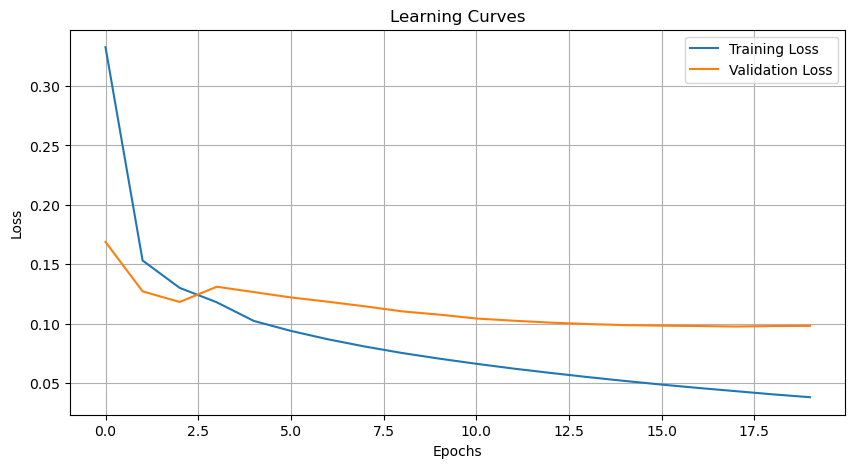

In [ ]:
import torch.optim as optim

cnn_model.to(device)


loss_module = nn.CrossEntropyLoss()

# You can use '0.0001' as learning rate for the optimizer
optimizer = optim.Adam(cnn_model.parameters(), lr=0.0001)

training_losses, validation_losses = train_model(
    cnn_model, loss_module, optimizer, train_loader, valid_loader, device, 'cnn-shallow'
)

plot_learning_curves(training_losses, validation_losses)

'''
training_losses, validation_losses = train_model(
    cnn_model, loss_module, optimizer, train_loader, valid_loader, device, 'cnn-shallow'
)
plot_learning_curves(training_losses, validation_losses) '''

Looking at the learning curve, epoch 18 seems to be the best point for generalization. Here, the validation loss is at its lowest, and after this point, it starts to increase, which suggests the model begins overfitting.

#### Testing the shallow CNN model

Next we will test the model using the test dataloader. The `test_model` function is responsible for evaluating a model on the test data. Given a model and the test data loader, the `test_model` function returns the true labels and the predicted probabilities.

In [ ]:
def test_model(model, test_loader):

    true_labels = []

    # predicted probabilities have probability that a sample belongs to positive class (having pneumonia)
    predicted_probabilities = []

    # Set model to eval mode
    model.eval()

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # Get the predicted class indices
            _, predicted = torch.max(outputs, 1)

            true_labels.extend(labels.cpu().numpy())

            # Compute softmax probabilities for each class and select the probability of the positive class
            probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
            predicted_probabilities.extend(probs)


    return true_labels, predicted_probabilities


Now, lest's the call the `test_model` function to evaluate the shallow CNN. For this purpose, you will load the checkpoint of the epoch you deemed as optimal (above) and use that model checkpoint for evaluation.

In [ ]:
# Load the model from the epoch you deem optimal

cnn_model = CNNShallow()
cnn_model.load_state_dict(torch.load('epoch_18_cnn-shallow.pth', weights_only=True))
cnn_model = cnn_model.to(device)


true_labels, predicted_probabilities = test_model(cnn_model, test_loader)

# Ensure the length of true labels and predicted probabilities match
assert(len(true_labels) == len(predicted_probabilities))


We will now plot the ROC curve. To do so, we are going to define the `plot_roc_curve` function. The function takes the true labels and the predicted probabilities as input and plots the roc curve along with it's area under the curve in the legend.

In [ ]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(labels, probs):
    fpr, tpr, thresholds = roc_curve(labels, probs)
    roc_auc = auc(fpr, tpr)

    # Compute and plot the ROC curve and specify the AUC value in the legend (or within the plot somewhere).
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    print('AUC: ', roc_auc)




Now let's call the function to plot the ROC curve for the shallow CNN model.

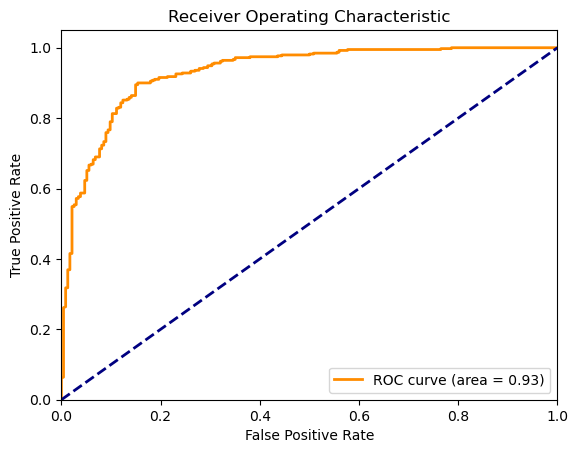

AUC:  0.9302542187157571


In [ ]:
plot_roc_curve(true_labels, predicted_probabilities)

### Section 3: Deep Convolutional neural network

Now we will implement another CNN architecture. The architecture is shown below. Implement it in the `CNNDeep` class, and train and test this model just like we did for the shallow network.

Let's define the CNNDeep class with the architecture shown below.

| Layer       | Parameters                                           |
|------------|------------------------------------------------------|
| Conv2d     | 16 3x3 kernels with padding=1                        |
| ReLU       | -                                                    |
| MaxPool2d  | 2x2 with stride=2                              |
| Conv2d     | 32 3x3 kernels with padding=1|
| ReLU       | -                                                    |
| MaxPool2d  | 2x2 with stride=2                               |
| Conv2d     | 64 3x3 kernels with padding=1|
| ReLU       | -                                                    |
| MaxPool2d  | 2x2 with stride=2                              |
| Flatten    | -                                                    |
| Dropout | p=0.25                                               |
| Linear     | output dimension of 512                   |
| ReLU       | -                                                    |
| Dropout | p=0.25                                               |
| Linear     | with 2 outputs                      |

In [ ]:
from torch import nn

class CNNDeep(nn.Module):
    # Create CNN using the architecture above, same input size as shallow CNN.
    def __init__(self, input_shape=(3, 112, 112)):
        super(CNNDeep, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(in_features=64 * 14 * 14, out_features=512)
        self.relu_fc1 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(in_features=512, out_features=2)  # Binary classification

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        x = self.flatten(x)
        x = self.dropout1(x)
        x = self.fc1(x)
        x = self.relu_fc1(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x




Let's instantiate the class and print the architecture.

In [ ]:
cnn_deep_model = CNNDeep()
print(cnn_deep_model)

CNNDeep(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=12544, out_features=512, bias=True)
  (relu_fc1): ReLU()
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)


Let's print the model summary to ensure the architecture matches with the specification. Your output should look like this:

<figure>
    <center>
        <img src="images/cnn_deep_arch.png" width="600" height="400">
        <figcaption>Deep CNN Architecture</figcaption>
     </center>
</figure>

In [ ]:
summary(cnn_deep_model, (3,112,112), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             448
              ReLU-2         [-1, 16, 112, 112]               0
         MaxPool2d-3           [-1, 16, 56, 56]               0
            Conv2d-4           [-1, 32, 56, 56]           4,640
              ReLU-5           [-1, 32, 56, 56]               0
         MaxPool2d-6           [-1, 32, 28, 28]               0
            Conv2d-7           [-1, 64, 28, 28]          18,496
              ReLU-8           [-1, 64, 28, 28]               0
         MaxPool2d-9           [-1, 64, 14, 14]               0
          Flatten-10                [-1, 12544]               0
          Dropout-11                [-1, 12544]               0
           Linear-12                  [-1, 512]       6,423,040
             ReLU-13                  [-1, 512]               0
          Dropout-14                  [

Now, let's train and evaluate the deep model as we did with the shallow model.

Epoch 1/20, Train Loss: 0.4394,  Valid Loss: 0.2317


Epoch 2/20, Train Loss: 0.2064,  Valid Loss: 0.1640


Epoch 3/20, Train Loss: 0.1607,  Valid Loss: 0.1429


Epoch 4/20, Train Loss: 0.1467,  Valid Loss: 0.1328


Epoch 5/20, Train Loss: 0.1319,  Valid Loss: 0.1216


Epoch 6/20, Train Loss: 0.1226,  Valid Loss: 0.1342


Epoch 7/20, Train Loss: 0.1136,  Valid Loss: 0.1200


Epoch 8/20, Train Loss: 0.1131,  Valid Loss: 0.1166


Epoch 9/20, Train Loss: 0.1077,  Valid Loss: 0.1093


Epoch 10/20, Train Loss: 0.1050,  Valid Loss: 0.1060


Epoch 11/20, Train Loss: 0.1062,  Valid Loss: 0.1060


Epoch 12/20, Train Loss: 0.1023,  Valid Loss: 0.1023


Epoch 13/20, Train Loss: 0.0960,  Valid Loss: 0.1017


Epoch 14/20, Train Loss: 0.0893,  Valid Loss: 0.1086


Epoch 15/20, Train Loss: 0.0968,  Valid Loss: 0.1007


Epoch 16/20, Train Loss: 0.0892,  Valid Loss: 0.0999


Epoch 17/20, Train Loss: 0.0881,  Valid Loss: 0.0998


Epoch 18/20, Train Loss: 0.0791,  Valid Loss: 0.0985


Epoch 19/20, Train Loss: 0.0757,  Valid Loss: 0.0978


Epoch 20/20, Train Loss: 0.0762,  Valid Loss: 0.0971


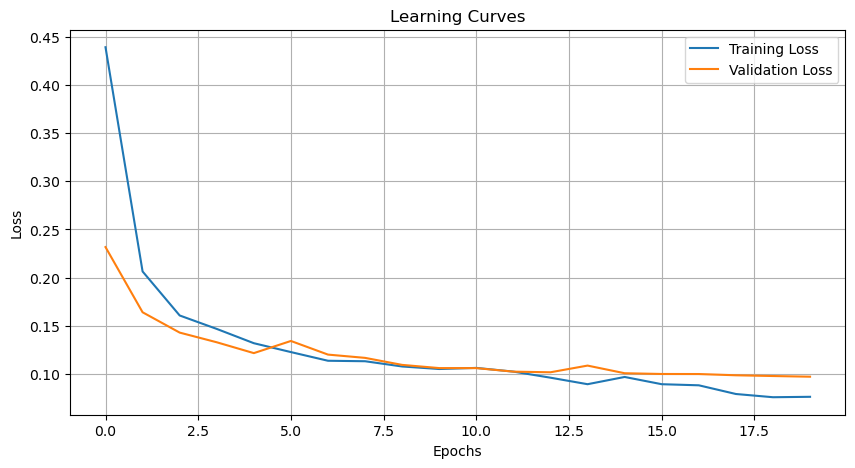

In [ ]:
cnn_deep_model.to(device)

loss_module = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_deep_model.parameters(), lr=0.0001)

training_losses, validation_losses = train_model(
    cnn_deep_model, loss_module, optimizer, train_loader, valid_loader, device, 'cnn-deep'
)
plot_learning_curves(training_losses, validation_losses)

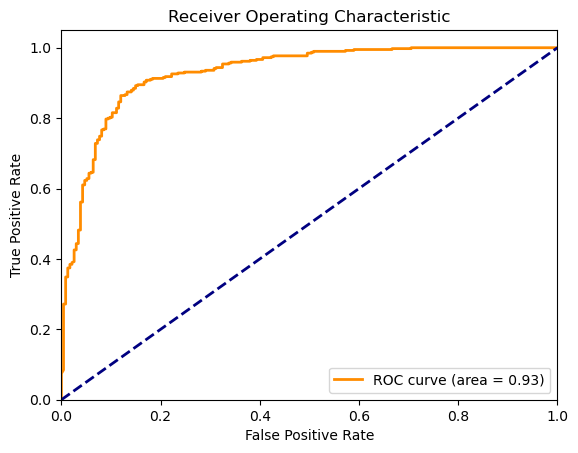

AUC:  0.9290105193951348


In [ ]:
# Load the model from the checkpoint you deem optimal
cnn_deep_model = CNNDeep()

# Load the state dictionary into the correct model (cnn_deep_model)
cnn_deep_model.load_state_dict(torch.load('epoch_20_cnn-deep.pth', weights_only=True)) # Changed cnn_model to cnn_deep_model
cnn_deep_model.to(device)

true_labels, predicted_probabilities = test_model(cnn_deep_model, test_loader)
plot_roc_curve(true_labels, predicted_probabilities)

### Section 4: Using a pretrained model

In this section, we load a MobileNet model with pretrained weights. We then replace the last fully connected layer (classifier) with a new one, having the desired number of output classes specific to our dataset. After this modification, we fine-tune the model on our training dataset. We will reuse the train and test model functions we've created above and evaluate the model in a similar manner.

You can read more about using pretrained models in pytorch here: https://pytorch.org/vision/stable/models.html


In [ ]:
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights


weights = MobileNet_V2_Weights.DEFAULT

mobilenet = mobilenet_v2(weights=weights)


# Define how many classes we have in our dataset
num_classes = 2

# Let's retrieve the featuremap that goes as input to the classification layer in mobilenet.
in_features = mobilenet.classifier[1].in_features

# Now replace the last fully connected layer of the classifier with a new one having the 'num_classes' as output
mobilenet.classifier[1] = nn.Linear(in_features, num_classes)


Now let's inspect the model's architecture using the print and summary functions.

In [ ]:
print(mobilenet)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [ ]:
summary(mobilenet, (3,112,112), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 56, 56]             864
       BatchNorm2d-2           [-1, 32, 56, 56]              64
             ReLU6-3           [-1, 32, 56, 56]               0
            Conv2d-4           [-1, 32, 56, 56]             288
       BatchNorm2d-5           [-1, 32, 56, 56]              64
             ReLU6-6           [-1, 32, 56, 56]               0
            Conv2d-7           [-1, 16, 56, 56]             512
       BatchNorm2d-8           [-1, 16, 56, 56]              32
  InvertedResidual-9           [-1, 16, 56, 56]               0
           Conv2d-10           [-1, 96, 56, 56]           1,536
      BatchNorm2d-11           [-1, 96, 56, 56]             192
            ReLU6-12           [-1, 96, 56, 56]               0
           Conv2d-13           [-1, 96, 28, 28]             864
      BatchNorm2d-14           [-1, 96,

Now, let's finetune and evaluate the pretrained mobilenet model using the functions defined above.

Epoch 1/20, Train Loss: 0.2970,  Valid Loss: 0.1416


Epoch 2/20, Train Loss: 0.0722,  Valid Loss: 0.1114


Epoch 3/20, Train Loss: 0.0225,  Valid Loss: 0.1152


Epoch 4/20, Train Loss: 0.0087,  Valid Loss: 0.1194


Epoch 5/20, Train Loss: 0.0043,  Valid Loss: 0.1263


Epoch 6/20, Train Loss: 0.0026,  Valid Loss: 0.1310


Epoch 7/20, Train Loss: 0.0018,  Valid Loss: 0.1347


Epoch 8/20, Train Loss: 0.0014,  Valid Loss: 0.1381


Epoch 9/20, Train Loss: 0.0011,  Valid Loss: 0.1420


Epoch 10/20, Train Loss: 0.0009,  Valid Loss: 0.1450


Epoch 11/20, Train Loss: 0.0008,  Valid Loss: 0.1480


Epoch 12/20, Train Loss: 0.0006,  Valid Loss: 0.1502


Epoch 13/20, Train Loss: 0.0006,  Valid Loss: 0.1530


Epoch 14/20, Train Loss: 0.0005,  Valid Loss: 0.1551


Epoch 15/20, Train Loss: 0.0004,  Valid Loss: 0.1573


Epoch 16/20, Train Loss: 0.0004,  Valid Loss: 0.1590


Epoch 17/20, Train Loss: 0.0003,  Valid Loss: 0.1603


Epoch 18/20, Train Loss: 0.0003,  Valid Loss: 0.1621


Epoch 19/20, Train Loss: 0.0002,  Valid Loss: 0.1636


Epoch 20/20, Train Loss: 0.0002,  Valid Loss: 0.1658


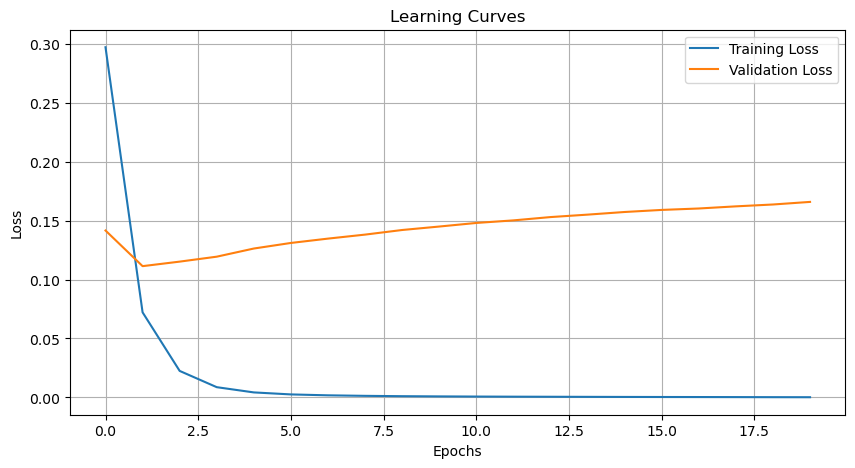

In [ ]:
mobilenet.to(device)
loss_module = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenet.parameters(), lr=0.0001)

training_losses, validation_losses = train_model(mobilenet, loss_module, optimizer, train_loader, valid_loader, device, 'mobilenet')
plot_learning_curves(training_losses, validation_losses)

/var/folders/kn/k5jj41rx3bn_nw985jpjf3nh0000gn/T/ipykernel_65704/3444996809.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f'epoch_2_{path}.pth'

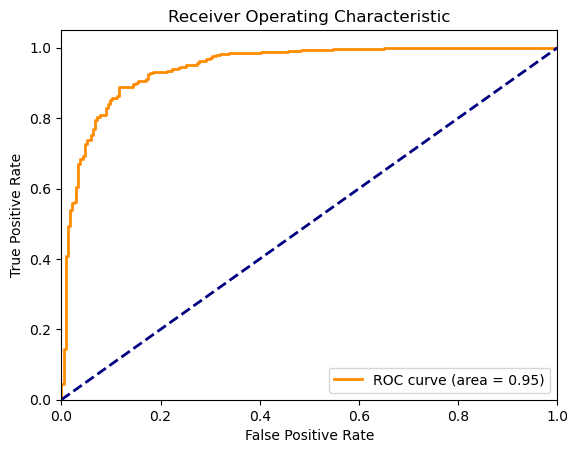

AUC:  0.9460223537146614


In [ ]:
mobilenet = mobilenet_v2()
mobilenet.classifier[1] = torch.nn.Linear(in_features=1280, out_features=2)

path = 'mobilenet'
state_dict = torch.load(f'epoch_2_{path}.pth')
mobilenet.load_state_dict(state_dict)

mobilenet.to(device)

true_labels, predicted_probabilities = test_model(mobilenet, test_loader)
plot_roc_curve(true_labels, predicted_probabilities)

MobileNet shows the highest ROC-AUC score of 0.9460, which means it’s strong at distinguishing classes, but its rising validation loss suggests it might overfit, making it less reliable on new data. However, CNN Shallow and CNN Deep are quite similar in performance, but CNN Shallow is the better pick because it’s simpler and less prone to overfitting. With a solid ROC-AUC of 0.930 and stable validation loss, CNN Shallow offers a reliable solution without the added complexity of CNN Deep, making it easier to use in real-world applications.

### Section 5: Model Interpretability with Grad-CAM

Grad-CAM (Gradient-weighted Class Activation Mapping) is a technique that leverages the spatial information preserved in convolutional layers to identify the regions of an input image that contributed for a classification decision. The output of Grad-CAM is a heatmap highlighting the crucial areas corresponding to a particular class. The authors of Grad-CAM argue that the last convolutional layers strike an optimal balance between high-level semantics and detailed spatial information  [<sup>1</sup>](#fn1). Hence in this section, we will implement Grad-CAM on the last convolution layer of the MobileNet model to visualize the important regions the model used for classification. We will randomly select six PNEUMONIA images from the provided 'train' folder. For these images, plot the gradcam heatmap and also output the predicted class and probability of these images. We will use `pytorch_grad_cam` module to implement grad-cam.

<span id="fn1"> <sup>1</sup> https://arxiv.org/pdf/1610.02391.pdf</span>


First, we will randomly choose six PNEUMONIA images from the 'train' folder. Complete the code code below.


In [ ]:
train_dataset_path = os.path.join(data_dir, 'train')

pneumonia_files = glob.glob(os.path.join(train_dataset_path, 'PNEUMONIA/*.jpeg'))
random_images = random.sample(pneumonia_files,6)

Next, we will define a function that takes as input the path of an image and the transforms needed and returns the image as both a tensor and an image object defined by the PIL class. This function is needed to run the Grad CAM analysis. This code is provided to you.

In [ ]:
from PIL import Image


# Function to load and preprocess an image for gradcam
def load_and_preprocess_image(image_path, transform):
    image = Image.open(image_path)
    if image.mode != 'RGB':
        image = image.convert('RGB')
    input_tensor = transform(image)
    input_tensor = input_tensor.unsqueeze(0)
    return input_tensor, image

Next, we will define a function to create saliency maps using Grad CAM for a given set of images. We will also utilize the `load_and_preprocess_image` function we defined above in the code below.

If you don't have `pytorch_grad_cam` installed, it can be installed via: `pip install grad-cam`.

In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

# Choose the mobilenet model
model = mobilenet

#If your model is on the GPU, put the input on the GPU as well
device = next(model.parameters()).device #Get device the model is on

# target layer is the last convolution layer
target_layers = [model.features[-1]]

# Intialize gradcam
cam = GradCAM(model=model, target_layers=target_layers)


def visualize_gradcam(model, cam, image_paths, transform):
    model.eval()
    fig, ax = plt.subplots(3, 2, figsize=(18,18))
    for i, image_path in enumerate(image_paths):

        row = i // 2
        col = i % 2

        input_tensor, image = load_and_preprocess_image(image_path, transform)

        # Move input_tensor to the same device as the model
        input_tensor = input_tensor.to(device) #Move tensor to same device as model

        # Get model prediction for the current image along with the probability that it is positive
        with torch.no_grad():
            outputs = model(input_tensor)
            _, predicted =torch.max(outputs,1) # model prediction for the current image
            probs = torch.nn.functional.softmax(outputs, dim=1)[0][predicted].item()
             # probability that it is positive

        if probs > 0.5:
            predicted_label = "PNEUMONIA"
        else:
            predicted_label = "NORMAL"
            probs = 1 - probs

        # Generate GradCAM heatmap
        grayscale_cam = cam(input_tensor=input_tensor, targets=None)
        grayscale_cam = grayscale_cam[0, :]
        image_np = np.array(image, dtype=np.float32) / 255.0
        resized_cam = np.array(Image.fromarray(grayscale_cam).resize(image_np.shape[:2][::-1]))

        # Overlay GradCAM heatmap on the original image
        visualization = show_cam_on_image(image_np, resized_cam, use_rgb=True)

        ax[row, col].imshow(visualization)
        ax[row, col].set_title(f'Predicted: {predicted_label} (Probability: {(probs):.4f})')

    plt.show()

Now let's call the function to visualize the saliency maps on the randomly chosen images.

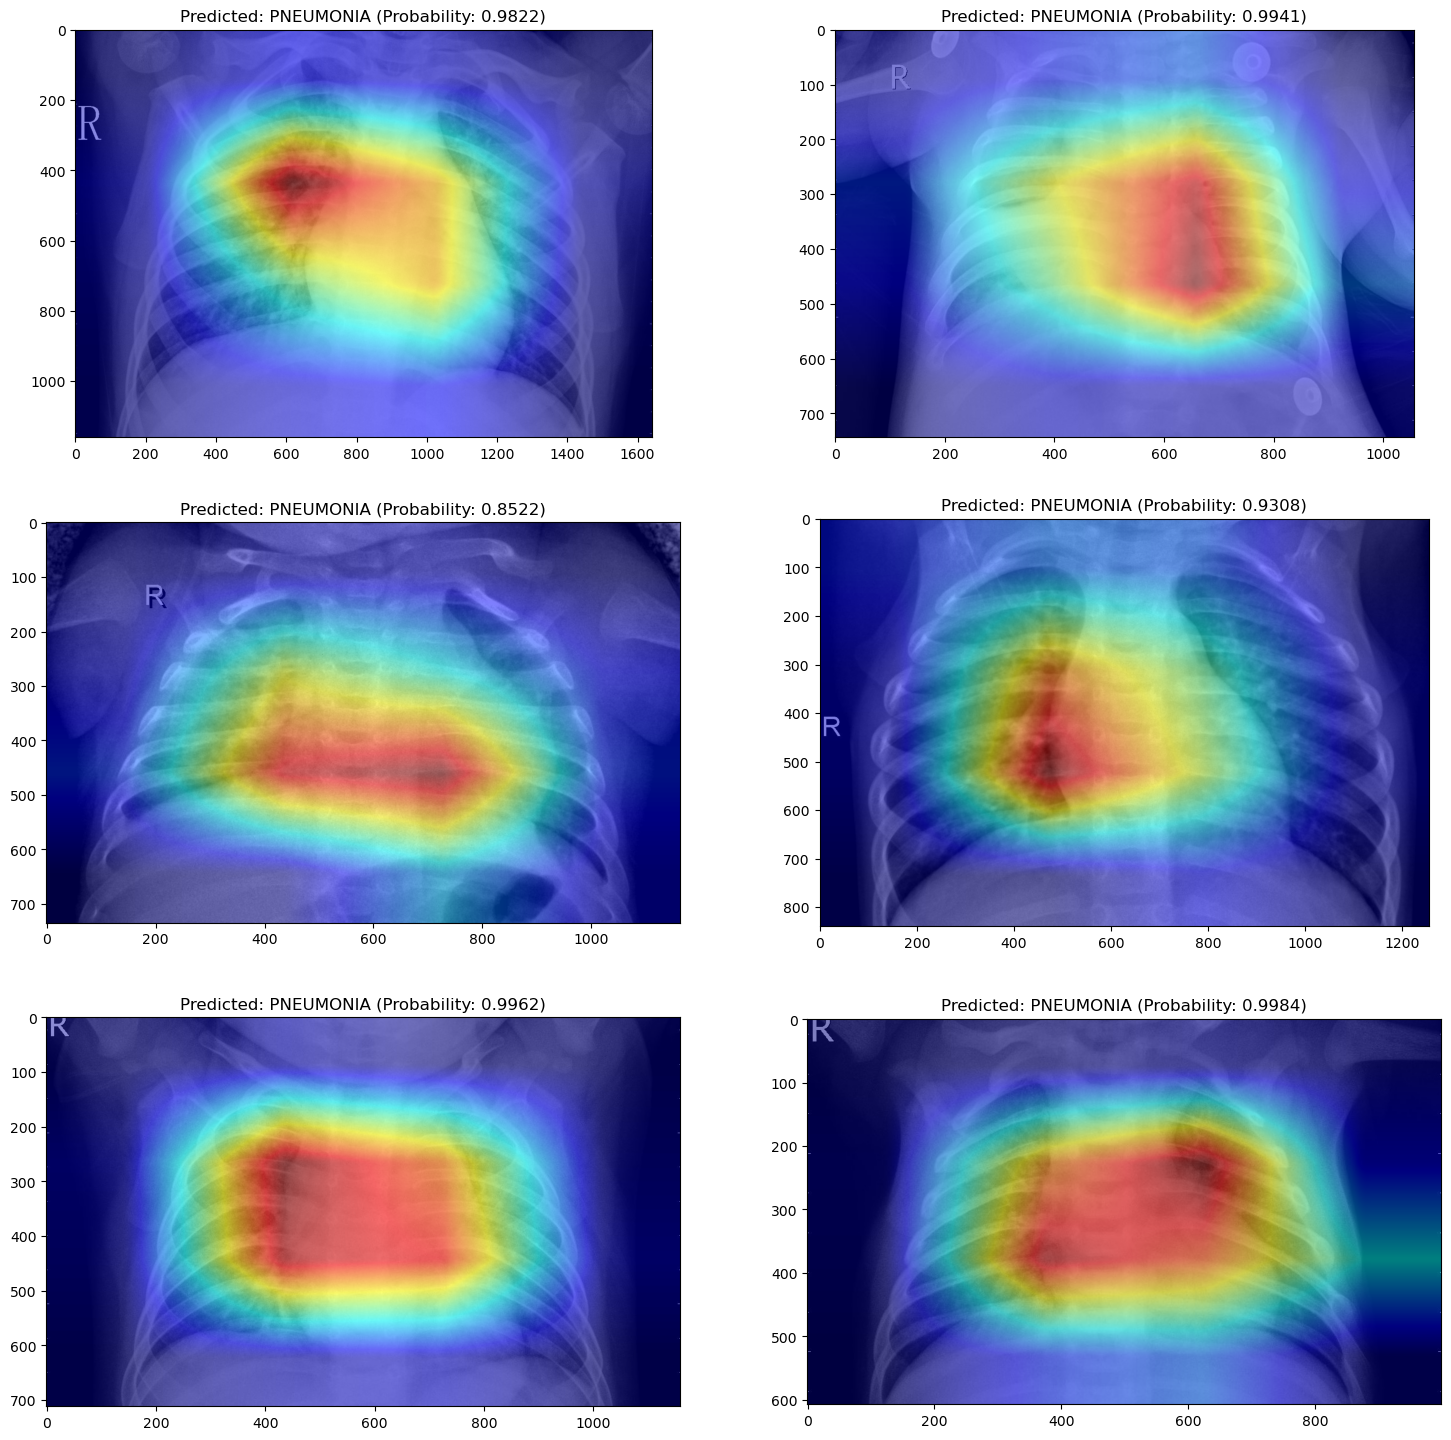

In [ ]:
visualize_gradcam(model, cam, random_images, transform)